# Machine Learning project
- Validate exoplanets Kepler disposition with machine learning methods

In [1]:
%config Completer.use_jedi = False  # enable code auto-completion
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report  # evaluation metrics

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Dataset


In [2]:
df = pd.read_csv('q1_q17_dr24_koi_2023.09.19_04.32.41.csv')
# Rename the columns
df.columns =['KepID',"KOIName","KeplerName","ExoplanetArchiveDisposition",
"ExoplanetDispositionKepler","DispositionScore","NotTransit-LikeFalsePositiveFlag",
"koi_fpflag_ss","CentroidOffsetFalsePositiveFlag","EphemerisMatchIndicatesContaminationFalsePositiveFlag",
"OrbitalPeriod.[Days]","OrbitalPeriodErr1.[Days]","OrbitalPeriodErr2.[Days]",
"TransitEpoch-bk","TransitEpoch-bkErr1","TransitEpoch-bkErr2",
"ImpactParameter","ImpactParameterErr1","ImpactParameterErr2",
"TransitDuration.[Hours]","TransitDurationErr1.[Hours]","TransitDurationErr2.[Hours]",
"TransitDepth.[ppm]","TransitDepthErr1.[ppm]","TransitDepthErr2.[ppm]",
"PlanetaryRadius","PlanetaryRadiusErr1","PlanetaryRadiusErr2",
"EquilibriumTemperature.[K]","EquilibriumTemperatureErr1.[K]","EquilibriumTemperatureErr2.[K]",
"InsolationFlux","InsolationFluxErr1","InsolationFlux2",
"TransitSignalToNoise",
"TCEPlanetNumber","TCEDeliveryName",
"StellarEffectiveTemperature.[K]","StellarEffectiveTemperatureErr1.[K]","StellarEffectiveTemperatureErr2.[K]",
"StellarSurfaceGravity","StellarSurfaceGravityErr1","StellarSurfaceGravityErr2",
"StellarRadius","StellarRadiusErr1","StellarRadiusErr2",
"RA.[deg]","Dec.[deg]","KeplerMagnitude.[mag]"]

df.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,ExoplanetDispositionKepler,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,...,StellarEffectiveTemperatureErr2.[K],StellarSurfaceGravity,StellarSurfaceGravityErr1,StellarSurfaceGravityErr2,StellarRadius,StellarRadiusErr1,StellarRadiusErr2,RA.[deg],Dec.[deg],KeplerMagnitude.[mag]
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,CANDIDATE,NaN,0,0,0,0,...,-50.0,4.455,0.025,-0.025,0.950,0.020,-0.020,286.80847,49.316399,11.338
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,CANDIDATE,NaN,0,1,0,0,...,-80.0,4.021,0.011,-0.011,1.991,0.018,-0.018,292.24728,47.969521,10.463
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,CANDIDATE,NaN,0,0,0,0,...,-91.0,4.590,0.011,-0.041,0.765,0.030,-0.022,297.70935,48.080853,9.174
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,CANDIDATE,NaN,0,1,0,0,...,-109.0,3.657,0.205,-0.107,2.992,0.469,-0.743,294.35654,38.947380,11.432
4,8554498,K00005.01,NaN,CANDIDATE,CANDIDATE,NaN,0,0,0,0,...,-75.0,4.003,0.011,-0.011,1.747,0.042,-0.042,289.73972,44.647419,11.665


# Modify dispositions
Modify KOI pdisposition and KOI disposition into binary form

In [3]:
# Drop columns that are not needed
df['ExoplanetCandidate'] = df['ExoplanetArchiveDisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
df['ExoplanetConfirmed'] = df['ExoplanetDispositionKepler'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

# Modify dataframe
Drop columns that are inconvenient. 

In [4]:
df.drop(columns=['KeplerName','KOIName','EquilibriumTemperatureErr1.[K]', 'StellarEffectiveTemperatureErr2.[K]',
                 'KepID','ExoplanetArchiveDisposition','ExoplanetDispositionKepler',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliveryName', 'EquilibriumTemperatureErr2.[K]', 'DispositionScore'], inplace=True)
df.head()

,OrbitalPeriod.[Days],OrbitalPeriodErr1.[Days],OrbitalPeriodErr2.[Days],TransitEpoch-bk,TransitEpoch-bkErr1,TransitEpoch-bkErr2,ImpactParameter,ImpactParameterErr1,ImpactParameterErr2,TransitDuration.[Hours],...,StellarSurfaceGravityErr1,StellarSurfaceGravityErr2,StellarRadius,StellarRadiusErr1,StellarRadiusErr2,RA.[deg],Dec.[deg],KeplerMagnitude.[mag],ExoplanetCandidate,ExoplanetConfirmed
0,2.470613,1.900000e-08,-1.900000e-08,122.763301,0.000006,-0.000006,0.8186,0.0003,-0.0006,1.74259,...,0.025,-0.025,0.950,0.020,-0.020,286.80847,49.316399,11.338,0,1
1,2.204735,3.800000e-08,-3.800000e-08,121.358572,0.000014,-0.000014,0.0010,0.0111,-0.0010,3.88216,...,0.011,-0.011,1.991,0.018,-0.018,292.24728,47.969521,10.463,0,1
2,4.887803,1.770000e-07,-1.770000e-07,124.813141,0.000028,-0.000028,0.0260,0.0486,-0.0260,2.36386,...,0.011,-0.041,0.765,0.030,-0.022,297.70935,48.080853,9.174,0,1
3,3.849372,1.304000e-06,-1.304000e-06,157.526738,0.000269,-0.000269,0.9193,0.0059,-0.0071,2.66050,...,0.205,-0.107,2.992,0.469,-0.743,294.35654,38.947380,11.432,0,1
4,4.780328,8.760000e-07,-8.760000e-07,132.974137,0.000152,-0.000152,0.9516,0.0011,-0.0023,2.03490,...,0.011,-0.011,1.747,0.042,-0.042,289.73972,44.647419,11.665,1,1


Drop rows from dataframe that include Nan value

In [5]:
df.isna().any()
df.shape

(7470, 37)

In [6]:
# Drop the rows that include Nan
df_cleaned = df.dropna()
df_cleaned.shape

(7291, 37)

# Features and labels

In [7]:
# Create a feature matrix X and label vector y.
y = df_cleaned['ExoplanetCandidate'].to_numpy()
X = df_cleaned.drop(columns=['ExoplanetCandidate', 'ExoplanetConfirmed']).to_numpy()
# Create test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=.40)

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Features in feature matrix

In [9]:
for column in df_cleaned.drop(columns=['ExoplanetCandidate', 'ExoplanetConfirmed']).columns:
    print(column)

OrbitalPeriod.[Days]
OrbitalPeriodErr1.[Days]
OrbitalPeriodErr2.[Days]
TransitEpoch-bk
TransitEpoch-bkErr1
TransitEpoch-bkErr2
ImpactParameter
ImpactParameterErr1
ImpactParameterErr2
TransitDuration.[Hours]
TransitDurationErr1.[Hours]
TransitDurationErr2.[Hours]
TransitDepth.[ppm]
TransitDepthErr1.[ppm]
TransitDepthErr2.[ppm]
PlanetaryRadius
PlanetaryRadiusErr1
PlanetaryRadiusErr2
EquilibriumTemperature.[K]
InsolationFlux
InsolationFluxErr1
InsolationFlux2
TransitSignalToNoise
TCEPlanetNumber
StellarEffectiveTemperature.[K]
StellarEffectiveTemperatureErr1.[K]
StellarSurfaceGravity
StellarSurfaceGravityErr1
StellarSurfaceGravityErr2
StellarRadius
StellarRadiusErr1
StellarRadiusErr2
RA.[deg]
Dec.[deg]
KeplerMagnitude.[mag]


# Logistic regression model
Create a logistic regression model and train it with scaled data.

In [10]:
# Create a logistic regression model
clf = LogisticRegression(C=100, max_iter=1000)
clf.fit(X_train, y_train) # Fit the model
y_pred = clf.predict(X_test) # Predict labels
# View accuracy score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.786767226602674


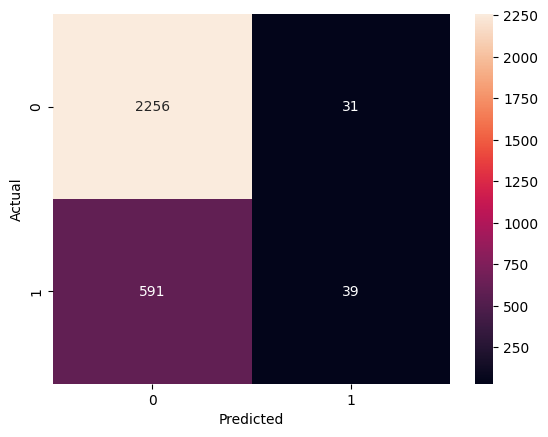

0.11142857142857143

In [11]:
# Plot the confusion matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusionMatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# compute f1 score
f1_score(y_test, y_pred)


In [12]:
# Classification report
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88      2287
           1       0.56      0.06      0.11       630

    accuracy                           0.79      2917
   macro avg       0.67      0.52      0.50      2917
weighted avg       0.74      0.79      0.71      2917



In [16]:
# Is there a ready loss funtion in sklearn?
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
logisticRegLoss = 0
# q: why does this give out nan? a: because y_pred is not a probability
# q: how to get the probability? a: use predict_proba
# q: how to multiply numpy w: use np.dot
# Give an example how to multiply numpy arrays

y_pred_proba = clf.predict_proba(X_test)
for i in range(len(y_test)):    
    logisticRegLoss += np.array(y_test[i] * np.log(y_pred_proba[i][0]) + (1 - y_test[i])).dot(np.log(1 - y_pred_proba[i][0]))
logisticRegLoss = -np.mean(logisticRegLoss)
print("Logistic Regression Loss: ", logisticRegLoss)


"""for i in range(len(y_pred)):
    logisticRegLoss += (y_test[i] * np.log(y_pred_proba[i]) + (1 - y_test[i]) * np.log(1 - y_pred_proba[i]))
logisticRegLoss = -np.mean(logisticRegLoss)
print("Logistic Regression Loss: ", logisticRegLoss)"""

Logistic Regression Loss:  nan


/var/folders/64/vx10yygj1v12t39t1vkm7k5h0000gn/T/ipykernel_73324/4013952028.py:11: RuntimeWarning: divide by zero encountered in log
  logisticRegLoss += np.array(y_test[i] * np.log(y_pred_proba[i][0]) + (1 - y_test[i])).dot(np.log(1 - y_pred_proba[i][0]))


'for i in range(len(y_pred)):\n    logisticRegLoss += (y_test[i] * np.log(y_pred_proba[i]) + (1 - y_test[i]) * np.log(1 - y_pred_proba[i]))\nlogisticRegLoss = -np.mean(logisticRegLoss)\nprint("Logistic Regression Loss: ", logisticRegLoss)'

In [14]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf_pca = LogisticRegression(C=100, max_iter=1000, class_weight='balanced')
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_pca)


0.7140898183064792